In [28]:
import requests
import os
import random
import json
import torch
import os
import kagglehub
import pickle
import math
import cv2

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA
from skimage.morphology import skeletonize
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split

from torchvision import transforms as A

Dataset Creation (IMAGE form to EMBEDDING form)

In [29]:
# path = kagglehub.dataset_download("albertozorzetto/carla-densely-annotated-driving-dataset")
# print("Path to dataset files:", path)

In [30]:
# # Download the CARLA dataset using the Kaggle API
# dataset_name = "albertozorzetto/carla-densely-annotated-driving-dataset"
# destination_path = "/content/datasets"

# import os
# # Install Kaggle API
# !pip install kaggle --upgrade
# # Upload kaggle.json for authentication
# from google.colab import files
# uploaded = files.upload()
# # Move kaggle.json to the proper directory
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# # Verify Kaggle is set up correctly
# !kaggle datasets list
# !kaggle datasets download -d {dataset_name} -p {destination_path} --unzip
# print("Path to dataset files:", destination_path)

# import tarfile
# images_path = os.path.join(destination_path, "images")
# labels_path = os.path.join(destination_path, "labels")
# # Create directories for extracted files
# os.makedirs(images_path, exist_ok=True)
# os.makedirs(labels_path, exist_ok=True)
# # Extract and manage .tar files
# tar_files = [f for f in os.listdir(destination_path) if f.endswith('.tar')]
# for tar_file in tar_files:
#     tar_path = os.path.join(destination_path, tar_file)
#     print(f"Extracting {tar_path}...")
#     with tarfile.open(tar_path) as tar:
#         # Determine the folder to extract based on the tar file name
#         if "images" in tar_file.lower():
#             tar.extractall(path=images_path)
#         elif "labels" in tar_file.lower():
#             tar.extractall(path=labels_path)
#         else:
#             print(f"Skipping unknown .tar file: {tar_file}")
#     os.remove(tar_path)  # Optional: Remove the .tar file after extraction
# print("All .tar files have been extracted.")
# print(f"Images folder: {images_path}")
# print(f"Labels folder: {labels_path}")

In [31]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
semantic_label_classes = ["Traffic Sign", "Building", "Fence", "Other", "Pedestrian", "Pole", "Road Line", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Unlabeled"]

root = "datasets"
images_dir = f"{root}/images"
labels_dir = f"{root}/labels"
waypoint_file = "dataset_waypoints.json"
bev_file = "dataset_bev.json"
batch_size = 2

skip = 500

*Saving the {way points} for passing to the LLM*

In [43]:
def get_mid_waypoint(waypoints):
    if len(waypoints) == 0:
        return None  # No waypoints available

    # Get the mid-point index
    mid_index = len(waypoints) // 2
    
    # If the list has an even number of points, average the two middle points
    mean_x = sum(wp[0] for wp in waypoints) / len(waypoints)
    mean_y = sum(wp[1] for wp in waypoints) / len(waypoints)
    mean_y = 600 - mean_y

    mid_waypoint = [mean_x, mean_y]

    return mid_waypoint

In [47]:
def generate_waypoints(label, num_waypoints):
    if len(label.shape) == 3:
        label = cv2.cvtColor(label, cv2.COLOR_RGB2GRAY)
    
    road_mask = (label == 90).astype(np.uint8)
    
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return []
    
    largest_contour = max(contours, key=cv2.contourArea)
    binary_image = (road_mask > 0).astype(np.uint8)
    skeleton = skeletonize(binary_image).astype(np.uint8)
    
    y_coords, x_coords = np.where(skeleton > 0)
    path_points = np.column_stack((x_coords, y_coords))
    
    # x_min, x_max = path_points[:, 0].min(), path_points[:, 0].max()
    # y_min, y_max = path_points[:, 1].min(), path_points[:, 1].max()

    # x_range = (x_max - x_min) * 0.25
    # y_range = (y_max - y_min) * 0.25

    # path_points = path_points[
    #     (path_points[:, 0] > x_min + x_range) & (path_points[:, 0] < x_max - x_range) &
    #     (path_points[:, 1] > y_min + y_range) & (path_points[:, 1] < y_max - y_range)
    # ]

    if len(path_points) == 0:
        return []

    sampled_indices = np.linspace(0, len(path_points) - 1, num_waypoints, dtype=int)
    waypoints = path_points[sampled_indices]

    num_selected_waypoints = min(25, len(path_points))
    sampled_indices = np.linspace(0, len(path_points) - 1, num_selected_waypoints, dtype=int)
    waypoints = path_points[sampled_indices]
    
    # print("Min/Max path points:", path_points.min(), path_points.max())

    # plt.imshow(skeleton, cmap="gray")
    # plt.scatter(x_coords, y_coords, c="red", marker="o")
    # plt.show()

    mid_waypoint = get_mid_waypoint(waypoints)
    # print("Mid Waypoint:", mid_waypoint)

    waypoints = mid_waypoint

    # print(mid_waypoint[0], 600 - mid_waypoint[1])

    # if len(waypoints) > 0:
    #     plt.figure(figsize=(10, 10))
    #     plt.imshow(label, cmap="gray")
    #     x = waypoints[0]
    #     y = 600 - waypoints[1]
    #     plt.scatter(x, y, c='red', marker='o')
    #     plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize=8, color='yellow', ha='right', va='bottom')
    #     plt.title("Extracted Waypoints")
    #     plt.show()

    return waypoints


In [48]:
def process_dataset(labels_dir, output_dir, num_waypoints):
    # os.makedirs(output_dir, exist_ok=True)
    dataset_waypoints = []

    for i in range(0, 28):
        k = "0" if i <= 9 else ""
        curr_folder_labels = f"{labels_dir}/Video_0{k}{i}"
        labels_path = [file for file in os.listdir(curr_folder_labels) if file.endswith(".png")]
        labels_path.sort()
        labels_path = labels_path[::skip]

        for label_file in labels_path:
            label_path = os.path.join(curr_folder_labels, label_file)
            label = Image.open(label_path)
            label_np = np.array(label)
            waypoints = generate_waypoints(label_np, num_waypoints=num_waypoints)
            output_label_path = os.path.join(output_dir, label_file)
            dataset_waypoints.append({
                "label": output_label_path,
                "waypoints": waypoints
            })
            # break

        with open(os.path.join(output_dir, waypoint_file), 'a') as wf:
            json.dump(dataset_waypoints, wf)
            wf.write("\n")
            # break

        if(i<27):
            print(f"\rProgress: {((i + 1) / 0.27):.2f} %", end = "")
        # break

    print(f"\nDone")

In [ ]:
process_dataset(labels_dir, root, 1000)

In [21]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, labels_dir):
        self.data = []
        ei = []
        cw = []

        for i in range(0, 28):
            k = "0" if i <= 9 else ""
            curr_folder_images = f"{images_dir}/Video_0{k}{i}"
            images_path = [file for file in os.listdir(curr_folder_images) if file.endswith(".png")]
            images_path.sort()
            images_path = images_path[::skip]

            for image_file in images_path:
                image_path = os.path.join(curr_folder_images, image_file)
                image = Image.open(image_path)
                image_embeddings = processor(text=semantic_label_classes, images=image, return_tensors="pt", padding=True)
                ei.append(image_embeddings['pixel_values'])

            with open(os.path.join(root, waypoint_file), "r") as wf:
                content = wf.read()
                data_list = content.splitlines()
                for data in data_list:
                    data = json.loads(data)
                    for i in data:
                        corresponding_waypoints = i['waypoints']
                        cw.append(corresponding_waypoints)
                        # print(corresponding_waypoints)
                        break
                    # break
            for e,c in zip(ei, cw):
                self.data.append((e,c))
                # break
            # break
        # print(self.data[0][1])
        # print(self.data[0][0])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embedding_inputs, embedding_labels = self.data[idx]
        return embedding_inputs, embedding_labels

In [ ]:
# Split indices for train and validation
dataset = SegmentationDataset(images_dir, labels_dir)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, pin_memory=True)

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = torch.utils.data.Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

**ALGORITHM 1: VL pretrained-M fine tuned with semi-disentangled outputs**

In [51]:
import requests
import os
import random
import json
import torch
import os
import kagglehub
import pickle
import math
import cv2

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA
from skimage.morphology import skeletonize
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split

from torchvision import transforms as A

In [52]:
def normalize(pixel_values):
    mini = pixel_values.min()
    maxi = pixel_values.max()
    pixel_values = (pixel_values - mini) / (maxi - mini)
    return pixel_values

In [53]:
def to_float(val):
    return val.float()

OUR VIT WP MODEL

In [54]:
class VitWPModel(nn.Module):
    def __init__(self):
        super(VitWPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)

        self.dropout = nn.Dropout(0.25)

    def forward(self, pixel_values):
        x = torch.relu(self.conv1(pixel_values))
        x = self.bn1(x)
        x = torch.max_pool2d(x, 2)
        
        x = torch.relu(self.conv2(x))
        x = self.bn2(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv3(x))
        x = self.bn3(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv4(x))
        x = self.bn4(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv5(x))
        x = self.bn5(x)
        x = torch.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        
        output = self.fc2(x)
        return output.view(-1, 1, 2).unsqueeze(0)

In [55]:
def model_output_generation(pixel_values, vit_wp_model):
    pixel_values = pixel_values.squeeze(1)
    outputs = vit_wp_model(pixel_values)
    return outputs

In [57]:
model_to_train = VitWPModel()

*--training set ups--*

In [58]:
def test(model_to_test, dataloader, optimizer, criterion):
    model_to_test.eval()
    running_loss = 0.0

    with torch.no_grad():
        for i, (p_val, way_p) in enumerate(dataloader):
            target = way_p[0].float()

            outputs = model_output_generation(p_val[0], model_to_test)
            loss = criterion(outputs[0][0][0], target)
            running_loss += loss.item()
            break

    return running_loss / len(dataloader)

In [59]:
def training(model_to_train, dataloader, optimizer, criterion):
    model_to_train.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, (p_val, way_p) in enumerate(dataloader):
        target = way_p[0].float()
        optimizer.zero_grad()

        outputs = model_output_generation(p_val[0], model_to_train)
        loss = criterion(outputs[0][0][0], target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        # break

    return running_loss / len(dataloader)

In [60]:
def validation(model_to_validate, dataloader, optimizer, criterion):
    model_to_validate.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for i, (p_val, way_p) in enumerate(dataloader):
            target = way_p[0].float()

            outputs = model_output_generation(p_val[0], model_to_validate)
            loss = criterion(outputs[0][0][0], target)
            running_loss += loss.item()
            # break

    return running_loss / len(dataloader)

In [ ]:
model_to_save = best_model_trained

In [54]:
torch.save(model__to_save.state_dict(), 'VitWPModel.pth')

In [83]:
driver_model = model_to_save

**ALGORITHM 2: Future Trajectory Prediction By Transformer using Multi Modal Inputs**

In [1]:
import io
import requests
import torch
import numpy
import time
import cv2

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from huggingface_hub import hf_hub_download
from transformers.image_transforms import rgb_to_id
from transformers import AutoImageProcessor, DetrForObjectDetection, DetrForSegmentation, TimeSeriesTransformerForPrediction, TimeSeriesTransformerConfig, pipeline

image to depth map

In [2]:
def image_to_depth_map(image):
    estimator = pipeline(task="depth-estimation", model="Intel/dpt-large")
    result = estimator(images=image)
    depth_map = result['predicted_depth']
    return depth_map

In [3]:
def plot_depth_map(depth_map, cord_x = 400, cord_y = 75):
    depth_map = depth_map.max() - depth_map
    height, width = depth_map.shape
    depth_at_cord = depth_map[cord_y-1, cord_x-1]
    print(f"Depth at co-ordinate ({cord_x}, {cord_y}) of the image: {depth_at_cord:.2f} meters")
    plt.scatter(cord_x, cord_y, color='red', marker='x')
    plt.imshow(depth_map, cmap = 'inferno')
    plt.colorbar()
    plt.show()

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Depth at co-ordinate (400, 75) of the image: 56.12 meters


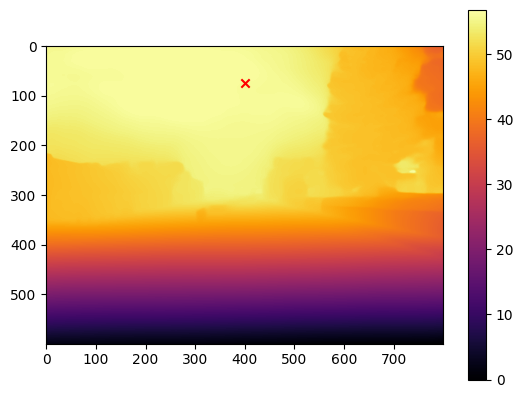

In [4]:
image = Image.open('datasets/images/Video_000/v000_0000.png')
depth_map = image_to_depth_map(image)
plot_depth_map(depth_map)

object detection section

In [6]:
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def object_detection(image):
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = detr_model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    objects = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

    return objects

In [17]:
def future_positions(objects, alpha = 0.1):
    trajectories = []
    
    for obj in objects:
        smoothed_positions = [obj]
        for t in range(0, len(obj)):
            smoothed_pos = alpha * obj[t] + (1 - alpha) * smoothed_positions[-1]
            smoothed_positions.append(smoothed_pos)
        future_positions = [smoothed_positions[-1]]
        trajectories.append(future_positions)

    new = []
    for i in trajectories:
        new.append(i[0].detach().numpy())

    trajectories = torch.tensor(new, dtype = torch.float32)
        
    return trajectories

In [18]:
objects = object_detection(image)

In [19]:
trajectories = future_positions(objects['boxes'])

depth map and object detection to bird eye view

In [20]:
def depth_map_to_bev(depth_map, objects, trajectories):
    f_x = 1000
    f_y = 1000
    c_x = 400
    c_y = 300
    bev_size = 200
    scale_factor = 15

    height, width = depth_map.shape
    bev_map = np.zeros((bev_size, bev_size), dtype=np.float32)

    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

    depth = depth_map[y_coords, x_coords].detach().numpy()
    X = (x_coords - c_x) * depth / f_x
    Y = (y_coords - c_y) * depth / f_y

    bev_x = np.clip((X * scale_factor).astype(int), 0, bev_size - 1)
    bev_y = np.clip((Y * scale_factor).astype(int), 0, bev_size - 1)

    for i in range(height * width):
        bev_map[bev_y.flat[i], bev_x.flat[i]] = max(bev_map[bev_y.flat[i], bev_x.flat[i]], depth.flat[i])

    for obj, traj in zip(objects, trajectories):
        x_min, y_min, x_max, y_max = obj
        x_min, y_min, x_max, y_max = x_min.item(), y_min.item(), x_max.item(), y_max.item()

        traj_x_min, traj_y_min, traj_x_max, traj_y_max = traj
        traj_x_min, traj_y_min, traj_x_max, traj_y_max = traj_x_min.item(), traj_y_min.item(), traj_x_max.item(), traj_y_max.item()

        obj_depths = depth_map[int(y_min):int(y_max), int(x_min):int(x_max)].detach().numpy()
        if obj_depths.size > 0:
            mean_depth = np.mean(obj_depths)
        else:
            mean_depth = 0
        
        X_min = (x_min - c_x) * mean_depth / f_x
        X_max = (x_max - c_x) * mean_depth / f_x
        Y_min = (y_min - c_y) * mean_depth / f_y
        Y_max = (y_max - c_y) * mean_depth / f_y
        Z = mean_depth
        bev_x_min = int(100 + X_min * scale_factor)
        bev_x_max = int(100 + X_max * scale_factor)
        bev_y_min = int(100 + Y_min * scale_factor)
        bev_y_max = int(100 + Y_max * scale_factor)

        traj_X_min = (traj_x_min - c_x) * mean_depth / f_x
        traj_X_max = (traj_x_max - c_x) * mean_depth / f_x
        traj_Y_min = (traj_y_min - c_y) * mean_depth / f_y
        traj_Y_max = (traj_y_max - c_y) * mean_depth / f_y
        traj_Z = mean_depth
        traj_bev_x_min = int(100 + traj_X_min * scale_factor)
        traj_bev_x_max = int(100 + traj_X_max * scale_factor)
        traj_bev_y_min = int(100 + traj_Y_min * scale_factor)
        traj_bev_y_max = int(100 + traj_Y_max * scale_factor)

        mean_depth = torch.tensor(mean_depth, dtype = torch.float32)
        if mean_depth > 4:
            bev_map[bev_y_min-10:bev_y_max+10, bev_x_min-10:bev_x_max+10] = bev_map.max() - mean_depth
            bev_map[traj_bev_y_min-10:traj_bev_y_max+10, traj_bev_x_min-10:traj_bev_x_max+10] = bev_map.max() - mean_depth

    bev_map = np.clip(bev_map, 0, 255)
    bev_map = bev_map.astype(np.uint8)

    return bev_map

In [21]:
def visualize_bev(bev_map):
    bev_map = bev_map.max() - bev_map
    bev_map = cv2.normalize(bev_map, None, 0, 255, cv2.NORM_MINMAX)
    bev_map = np.uint8(bev_map)
    plt.imshow(bev_map, cmap="jet", interpolation='nearest')
    plt.colorbar()
    plt.show()

In [22]:
bev_map = depth_map_to_bev(depth_map, objects['boxes'], trajectories)

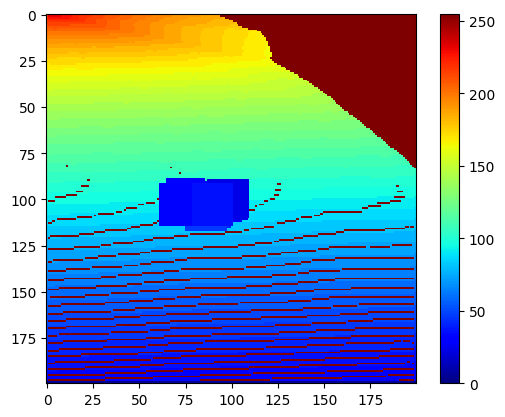

In [23]:
visualize_bev(bev_map)

In [24]:
def get_waypoint(bev_map):
    bev_map = bev_map.max() - bev_map
    bev_map = cv2.normalize(bev_map, None, 0, 255, cv2.NORM_MINMAX)
    bev_map = np.uint8(bev_map)
    x_mid = 400
    dist = float('inf')

    for y in range(0,200):
        for x in range(0,200):
            b = bev_map[y,x]
            if b > 91:
                if dist > abs(x_mid - x):
                    cord_x = x
                    cord_y = y
                    dist = abs(x_mid - x)
                break

    return cord_x * 4, cord_y * 3

Depth at co-ordinate (452, 312) of the image: 52.55 meters


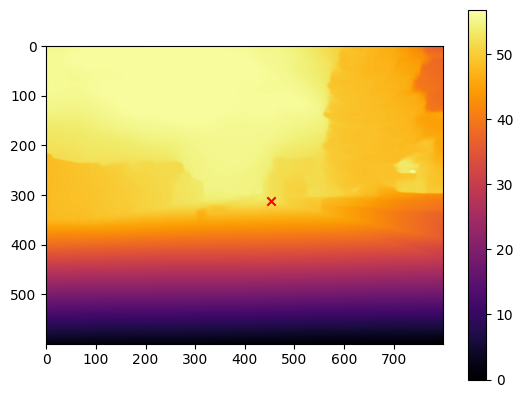

In [25]:
wp_x, wp_y = get_waypoint(bev_map)
plot_depth_map(depth_map, wp_x, wp_y)

*Saving BEV details*

In [26]:
def prepare_bev_dataset(images_dir, output_dir, bev_map):
    # os.makedirs(output_dir, exist_ok=True)
    bevs = []

    for i in range(0, 28):
        k = "0" if i <= 9 else ""
        curr_folder_images = f"{images_dir}/Video_0{k}{i}"
        images_path = [file for file in os.listdir(curr_folder_images) if file.endswith(".png")]
        images_path.sort()
        images_path = images_path[::skip*10]

        for image_file in images_path:
            image_path = os.path.join(curr_folder_images, image_file)
            image = Image.open(image_path)
            image_np = np.array(image)

            depth_map = image_to_depth_map(image)
            objects = object_detection(image)
            trajectories = future_positions(objects['boxes'])
            bev_map = depth_map_to_bev(depth_map, objects['boxes'], trajectories)
            wp_x, wp_y = get_waypoint(bev_map)

            output_image_path = os.path.join(output_dir, image_file)
            bevs.append({
                "image": output_image_path,
                "bev_map": bev_map.tolist(),
                "way_point": [wp_x, wp_y]
            })
            # break

        with open(os.path.join(output_dir, bev_file), 'a') as wf:
            json.dump(bevs, wf)
            wf.write("\n")
            # break

        if(i<27):
            print(f"\rProgress: {((i + 1) / 0.27):.2f} %", end = "")
        # break

    print(f"\nDone")

In [32]:
prepare_bev_dataset(images_dir, root, bev_map)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 3.70 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 7.41 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 11.11 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 14.81 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 18.52 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 22.22 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 25.93 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 29.63 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 33.33 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 37.04 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 40.74 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 44.44 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 48.15 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 51.85 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 55.56 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 59.26 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 62.96 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 66.67 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 70.37 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 74.07 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 77.78 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 81.48 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 85.19 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 88.89 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 92.59 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 96.30 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Progress: 100.00 %

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Done


OUR TEMPORAL FUSION MODEL

*--training set ups--*

In [27]:
def test(model_to_test, dataloader, optimizer, criterion):
    model_to_test.eval()
    running_loss = 0.0

    with torch.no_grad():
        for i, (p_val, way_p) in enumerate(dataloader):
            target = way_p[0].float()

            outputs, _ = predict_trajectory(p_val[0])
            print(outputs)
            # loss = criterion(outputs, target)
            # running_loss += loss.item()
            break

    return running_loss / len(dataloader)

In [28]:
def training(model_to_train, dataloader, optimizer, criterion):
    model_to_train.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for i, (p_val, way_p) in enumerate(dataloader):
        target = way_p[0].float()
        optimizer.zero_grad()

        outputs, _ = predict_trajectory(p_val[0])
        print(outputs)
        # loss = criterion(outputs, target)
        # running_loss += loss.item()

        # loss.backward()
        # optimizer.step()
        break

    return running_loss / len(dataloader)

In [29]:
def validation(model_to_validate, dataloader, optimizer, criterion):
    model_to_validate.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for i, (p_val, way_p) in enumerate(dataloader):
            target = way_p[0].float()

            outputs, _ = predict_trajectory(p_val[0])
            print(outputs)
            # loss = criterion(outputs, target)
            # running_loss += loss.item()
            break

    return running_loss / len(dataloader)

In [ ]:
model_to_save = best_model_trained

In [ ]:
torch.save(model_to_save.state_dict(), 'MultiModalTransformerModel.pth')

In [96]:
driver_model = model_to_save

**Model Management Section**

In [61]:
optimizer = optim.Adam(model_to_train.parameters(), lr=1e-2)
criterion = nn.MSELoss()
num_epochs = 20
lr = 1e-1

test section

In [ ]:
test_loss = test(model_to_train, dataloader, optimizer, criterion)
print(f"test loss is: {test_loss}")

training loop

In [64]:
num_epochs = 20
lr = 1e-1

In [ ]:
for i in range(0,3):
  lr = lr / 10
  optimizer = optim.Adam(model_to_train.parameters(), lr=lr)
  best_train_loss = float('inf')
  best_val_loss = float('inf')
  patience = 15
  print(f"Setting Learning rate to: {lr}")

  for epoch in range(num_epochs):
    best_model_trained = model_to_train
    if(patience == 0):
      break
    
    train_loss = training(model_to_train, train_loader, optimizer, criterion)
    val_loss = validation(model_to_train, val_loader, optimizer, criterion)
    
    if(train_loss > (best_train_loss * 0.95) or (val_loss > (best_val_loss * 0.95))):
      model_to_train = best_model_trained
      patience -= 1
    else:
      best_train_loss = train_loss
      best_val_loss = val_loss
      best_model_trained = model_to_train
      patience = 15
      # torch.save(model_to_train.state_dict(), '/content/drive/MyDrive/my_model.pth')
    print(f"\rEpoch {epoch + 1}/{num_epochs}, train-Loss: {train_loss:.1f}, val-Loss: {val_loss:.1f}     ", end = "")#, patience: {patience}", end = "")
    # break
  print("\n")
  # break

**CarLA simulation**

redundent code

In [23]:
import requests
import os
import random
import json
import torch
import os
import kagglehub
import pickle
import math
import cv2

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from collections import Counter
from sklearn.decomposition import PCA
from skimage.morphology import skeletonize
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split

from torchvision import transforms as A

In [ ]:
class VitWPModel(nn.Module):
    def __init__(self):
        super(VitWPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 512, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)

        self.dropout = nn.Dropout(0.25)

    def forward(self, pixel_values):
        x = torch.relu(self.conv1(pixel_values))
        x = self.bn1(x)
        x = torch.max_pool2d(x, 2)
        
        x = torch.relu(self.conv2(x))
        x = self.bn2(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv3(x))
        x = self.bn3(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv4(x))
        x = self.bn4(x)
        x = torch.max_pool2d(x, 2)

        x = torch.relu(self.conv5(x))
        x = self.bn5(x)
        x = torch.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        
        output = self.fc2(x)
        return output.view(-1, 1, 2).unsqueeze(0)

In [27]:
def to_float(val):
    return val.float()

In [28]:
def model_output_generation(pixel_values, vit_wp_model):
    pixel_values = pixel_values.squeeze(1)
    outputs = vit_wp_model(pixel_values)
    return outputs

In [29]:
import carla
import random
import time
import kagglehub
import os
import torch
import requests
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
semantic_label_classes = ["Traffic Sign", "Building", "Fence", "Other", "Pedestrian", "Pole", "Road Line", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Unlabeled"]

In [3]:
client = carla.Client('localhost', 2000)
world = client.get_world()
blueprint_library = world.get_blueprint_library()

netstat -an | findstr 2000
ping localhost

In [4]:
def remove_all_actors():
    actors = world.get_actors()
    for actor in actors:
        if 'vehicle' in actor.type_id:
            actor.destroy()
    world.tick()
    print("previous ones destroyed")

In [ ]:
remove_all_actors()

In [6]:
ego_blueprint = blueprint_library.filter('*model3')[0]
spawn_points = world.get_map().get_spawn_points()[0]
ego = world.spawn_actor(ego_blueprint, spawn_points)

camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '800')
camera_bp.set_attribute('image_size_y', '600')
camera_bp.set_attribute('fov', '110')
camera_transform = carla.Transform(carla.Location(x = 1.5, z = 2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=ego)

In [7]:
def EGO_relative_view(EGO):
    view = EGO.get_transform().location + carla.Location(x=0, y=0, z=10)
    return view

In [8]:
def set_cam_to_EGO(EGO, angle = 65):
    spectator = world.get_spectator()
    vehicle_transform = EGO.get_transform()
    spectator.set_transform(
        carla.Transform(
            EGO_relative_view(EGO),
            carla.Rotation(pitch = -angle, yaw = vehicle_transform.rotation.yaw, roll = 0)
        )
    )

*functions to control*

In [9]:
def steering(x, intended_x, s_power):
    towards = intended_x - x
    steer = towards * 0.0002
    steer = steer * (1 + s_power) / 1.5
    steer = max(-1, min(steer, 1))
    return steer

In [10]:
def TandB(y_mid, intended_y_mid, curr_y = 25):
    if(intended_y_mid <= curr_y):
        return 0, 1
    intended_y_mid = intended_y_mid if intended_y_mid < y_mid else y_mid
    return max(0.3, min((y_mid - intended_y_mid) / (2 * y_mid), 1)), 0

In [11]:
def process_image(image):
    array = np.frombuffer(image.raw_data, dtype=np.uint8)
    array = array.reshape((image.height, image.width, 4))
    return Image.fromarray(array[:, :, :3])

In [12]:
def image_to_emb(image):
    global emb, image_1
    image_1 = image
    image = process_image(image)
    emb = processor(text=semantic_label_classes, images=image, return_tensors="pt", padding=True)

In [13]:
def normalize_wp(way_p_1, top_w,top_h):
    way_p = way_p_1

    mini_f = float('inf')
    maxi_f = -float('inf')
    for i in way_p[0]:
        if(maxi_f < i[0]):
            maxi_f = i[0]
        if(mini_f > i[0]):
            mini_f = i[0]
        
    mini_s = float('inf')
    maxi_s = -float('inf')
    for i in way_p[1]:
        if(maxi_s < i[1]):
            maxi_s = i[1]
        if(mini_s > i[1]):
            mini_s = i[1]
        
    for i in way_p:
        i[0] = (i[0] - mini_f) / (maxi_f - mini_f)
        i[1] = (i[1] - mini_s) / (maxi_s - mini_s)
        i[0] *= top_h
        i[1] *= top_w

    return way_p

In [14]:
set_cam_to_EGO(ego)

calculation of metrics

In [15]:
RC = 0
IS = 0
DS = 0

*--route completion--*

In [16]:
def evaluate_RC(intended_x_mid, ego_x_position, intended_y_mid, ego_y_position):
    global rcc
    if intended_y_mid > ego_y_position:
        dist = math.sqrt(((intended_x_mid - ego_x_position) ** 2) + ((intended_y_mid - ego_y_position) ** 2))
        if dist <= 900:
            rcc = rcc + 1

*--infraction score--*

In [17]:
class CollisionSensor(object):
    def __init__(self, vehicle):
        self.vehicle = vehicle
        self.world = vehicle.get_world()
        self.collision_history = []

        blueprint = self.world.get_blueprint_library().find('sensor.other.collision')
        self.sensor = self.world.spawn_actor(blueprint, carla.Transform(), attach_to=self.vehicle)
        self.sensor.listen(self._on_collision)

    def _on_collision(self, event):
        self.collision_history.append(event)
        
    def get_collision_count(self):
        return len(self.collision_history)

In [18]:
def detect_red_light_violation():
    global red_light_violations
    ego_position = ego.get_location()
    traffic_lights = world.get_traffic_lights()
    red_light_violation = False
    for traffic_light in traffic_lights:
        light_position = traffic_light.get_location()
        distance_to_light = ego_position.distance(light_position)
        if distance_to_light < 20.0:
            if traffic_light.get_state() == carla.TrafficLightState.Red:
                red_light_violation = True

In [19]:
def evaluate_IS(speed_limit, red_light_violations, collision_sensor):
    global isc

    velocity = ego.get_velocity()
    speed = (velocity.x**2 + velocity.y**2 + velocity.z**2) ** 0.5 * 3.6
    
    if speed > speed_limit:
        isc -= 1
        
    if red_light_violations:
        isc -= 1

    if collision_sensor.get_collision_count() > 0:
        isc -= 10

    if isc < 0:
        isc = 0

*--driving score--*

In [20]:
def evaluate_DS():
    global RC
    global IS
    global dsc
    dsc = (RC + IS) / 2

controlling based on vit_wp_model

In [ ]:
driver_model = VitWPModel()
driver_model.load_state_dict(torch.load('VitWPModel.pth', map_location=torch.device('cpu')))

In [ ]:
print("started")

emb = None
prev_emb = None
image_1 = None

RC = 0
IS = 0
DS = 0
rcc = 0
isc = 100

start_time = time.time()
pe = {}
e = {}
idx = 0

speed_limit = 50
red_light_violations = False

set_cam_to_EGO(ego)
camera.listen(image_to_emb) #changes emb, image_1 globally

collision_sensor = CollisionSensor(ego)

init_pos = ego.get_transform().location
distance = 0.0
fin_pos = init_pos

while emb is None:
    world.tick()

if prev_emb:
    for i in prev_emb.keys():
        pe[i] = prev_emb[i]
for i in emb.keys():
    e[i] = emb[i]

while True:
    world.wait_for_tick()
    e = emb['pixel_values']
    # print(f"unique emb['pixel_values]: {e}")
    if prev_emb:
        pe = prev_emb['pixel_values']
        # print(f"unique prev_emb['pixel_values]: {pe}")
        if not torch.equal(e,pe):
            idx = idx + 1

            scene_x, scene_y = 800, 600
            ego_x_mid = scene_x/2
            ego_y_mid = scene_y/2

            outputs = model_output_generation(e, driver_model)[0][0][0]
            waypoint = outputs.detach().numpy()

            ego_x_position = ego_x_mid
            ego_y_position = 600
            
            intended_x = waypoint[0]
            intended_y = aypoint[1]
            
            curr_pos = ego.get_transform().location
            dx = curr_pos.x - fin_pos.x
            dy = curr_pos.y - fin_pos.y
            dz = curr_pos.z - fin_pos.z
            d = math.sqrt((dx ** 2) + (dy ** 2) + (dz ** 2))
            distance = distance + d

            evaluate_RC(intended_x, ego_x_position, intended_y, ego_y_position)
            evaluate_IS(speed_limit, red_light_violations, collision_sensor)

            throttle, brake = TandB(ego_y_mid, intended_y, ego_y_position)

            velocity = ego.get_velocity()
            speed = math.sqrt((velocity.x**2 + velocity.y**2 + velocity.z**2)) / 5
            s_power = (1 - brake) * (1 - speed)

            steer = steering(ego_x_position, intended_x, s_power)

            # print("\r", waypoint, intended_x, intended_y, end = "")
            print(f"\rpredicted: {waypoint}, mid: ({ego_x_mid:.1f}, {ego_y_mid:.1f}), going towards: ({intended_x:.1f}, {intended_y:.1f}), with b:{brake}, t:{throttle:.1f}, s:{steer:.1f}      ", end = "")

            control = carla.VehicleControl()
            waypoint = outputs.detach().numpy()
            control.steer = steer
            control.throttle = throttle
            control.brake = brake
            ego.apply_control(control)
            set_cam_to_EGO(ego)
            
    if(time.time() >= start_time + 60):
        break
    prev_emb = emb
if(distance > 0):
    RC = rcc * 100 / distance
    IS = isc * 100 / distance
evaluate_DS()

print(f"\nRC is: {RC:.2f}, DS is: {DS:.2f}, IS is: {IS:.2f}")

In [ ]:
camera.stop()
remove_all_actors()

ego_blueprint = blueprint_library.filter('*model3')[0]
spawn_points = world.get_map().get_spawn_points()[0]
ego = world.spawn_actor(ego_blueprint, spawn_points)

camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '1920')
camera_bp.set_attribute('image_size_y', '1080')
camera_bp.set_attribute('fov', '110')
camera_transform = carla.Transform(carla.Location(x = 1.5, z = 2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=ego)

set_cam_to_EGO(ego, 65)
print("stopped")